## TO-DO
- Implement object detection
- Fix losses (I think)
- Learning rate optimisations
- Evaluation (metrics)

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from utils.loader import DataLoader
import matplotlib.pyplot as plt

In [19]:
batch_size = 1200

In [20]:
loader = DataLoader(batch_size)
img_ds = loader.get_image_ds().repeat()
masks_ds = loader.get_mask_ds().repeat()
label_ds = loader.get_binary_ds().repeat()
bbox_ds = loader.get_bboxes_ds().repeat()

In [14]:
img_height, img_width, channels = list(img_ds.take(1))[0].shape[-3:]

Plot some examples (Ignore if training)

In [21]:
# Make some examples
#examples = tf.data.Dataset.zip((img_ds, masks_ds, label_ds)).as_numpy_iterator()
examples = label_ds.as_numpy_iterator()

In [26]:
display_list = next(examples)
np.sum(display_list)

600.0

In [6]:
def fix_bbox(bbox):
    temp = np.zeros_like(bbox)
    temp[0], temp[1] = bbox[1], bbox[0]
    temp[2], temp[3] = bbox[3], bbox[2]
    return temp

ValueError: cannot reshape array of size 64 into shape (1,1,4)

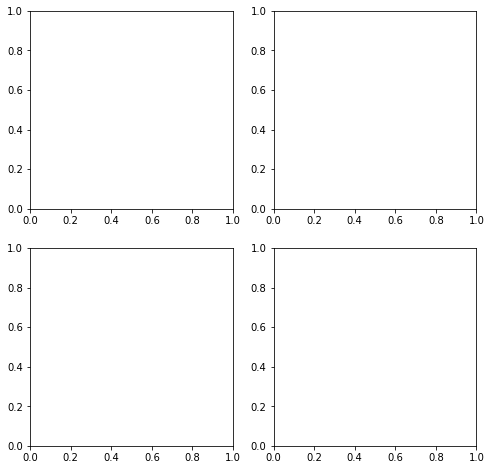

In [7]:
# View some examples
display_list = next(examples)
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    box_img = tf.image.draw_bounding_boxes(tf.expand_dims(display_list[0][i,...], 0), fix_bbox(display_list[2][i]).reshape([1,1,4])/256, np.array([[255, 0, 0]]))
    ax1[i].imshow(tf.keras.utils.array_to_img(tf.squeeze(box_img)))
    ax2[i].imshow((display_list[1][i,...]))

Build our MTL

In [12]:
#Augment training data to reduce overfitting by creating a pre-proccessing layer that only activates in training

data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"), #random hor flip
        tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"), # random ver flip
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.5), #random rotation up to 180deg
        # tf.layers.experimental.preprocessing.RandomZoom((0,-.75)), #up to 75% zoom
    ]
)

In [22]:
# Build base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, input_shape=[img_height, img_width, 3], weights='imagenet'
)

In [23]:
# Picked each final decoding layer in the EffNet architecture
layer_names = [
    'block2a_expand_activation',
    'block3a_expand_activation',
    'block4a_expand_activation',
    'block6a_expand_activation',
    'block7a_project_conv'
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs, name='Encoder')
encoder.trainable = False

In [30]:
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [17]:
def upsample_block(filters, size):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
# Build the up-sampler
inputs = tf.keras.layers.Input(shape=[img_height, img_width, 3])

# Downsampling through the model
skips = encoder(inputs)
x = skips[-1]
inter = skips[-1] # Save for output to binary classifier
skips = reversed(skips[:-1])

up_stack = [
    upsample_block(512, 3),
    upsample_block(256, 3),
    upsample_block(128, 3),
    upsample_block(64, 3), 
]

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

# Our multiple outputs
seg_out = tf.keras.layers.Conv2DTranspose(
    filters=3, kernel_size=3, strides=2,
    padding='same', name='segnet_out')(x)
bin_class_out = tf.keras.layers.GlobalAveragePooling2D(name='bin_class_pooling')(inter)
bin_class_out = keras.layers.Dense(2, activation='softmax', name='bin_class_out')(bin_class_out)

model = tf.keras.Model(inputs=inputs, outputs=[seg_out, bin_class_out])


In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Encoder (Functional)           [(None, 128, 128, 9  3633571     ['input_7[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 240                                           

Test out model

In [ ]:
b = generator_img()
a = next(b)
i = 0

Dog: 0.4352826774120331,   Cat: 0.5647172927856445


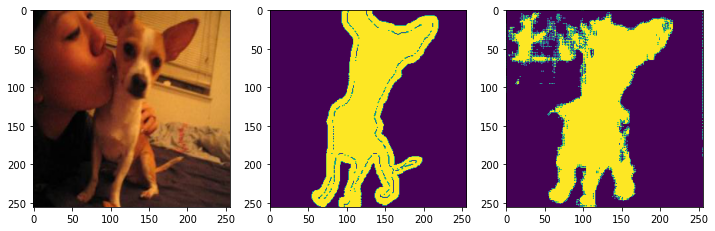

In [102]:
seg_pred, bin_pred = model.predict(a[0][i][tf.newaxis,...])
seg_max = tf.argmax(seg_pred, axis=-1)
seg_max = seg_max[..., tf.newaxis][0]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,12))
ax1.imshow(tf.keras.utils.array_to_img(tf.squeeze(a[0][i,...])))
ax2.imshow(tf.keras.utils.array_to_img(a[1][0][i,...]))
ax3.imshow(seg_max)
print(f'Dog: {bin_pred[0][0]},   Cat: {bin_pred[0][1]}') # 0 is dog, 1 is cat
i += 1

Train model

In [25]:
#keras.optimizers.Adam(4.3e-5) Errors here?
model.compile(optimizer=keras.optimizers.Adam(),
              loss={'segnet_out' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    'bin_class_out' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
              metrics=['accuracy'])

In [26]:
def generator_img():
    a = img_ds.as_numpy_iterator()
    b = masks_ds.as_numpy_iterator()
    c = label_ds.as_numpy_iterator()
    while True: # Add shuffling
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        
        # Regularisation/augmentation
        X = data_augmentation(X, training=True)
        
        yield X, [Y1, Y2]

In [27]:
model.fit(generator_img(),epochs=10, steps_per_epoch=2000//16)

Epoch 1/10


C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


125/125 [==============================] - 450s 4s/step - loss: 1.7132 - segnet_out_loss: 0.8154 - bin_class_out_loss: 0.8978 - segnet_out_accuracy: 0.6330 - bin_class_out_accuracy: 0.7435
Epoch 2/10
125/125 [==============================] - 445s 4s/step - loss: 1.0121 - segnet_out_loss: 0.3733 - bin_class_out_loss: 0.6387 - segnet_out_accuracy: 0.6119 - bin_class_out_accuracy: 0.5170
Epoch 3/10
125/125 [==============================] - 449s 4s/step - loss: 0.7577 - segnet_out_loss: 0.2634 - bin_class_out_loss: 0.4944 - segnet_out_accuracy: 0.5973 - bin_class_out_accuracy: 0.4450
Epoch 4/10
125/125 [==============================] - 471s 4s/step - loss: 0.6075 - segnet_out_loss: 0.2152 - bin_class_out_loss: 0.3923 - segnet_out_accuracy: 0.5920 - bin_class_out_accuracy: 0.4520
Epoch 5/10
 24/125 [====>.........................] - ETA: 6:19 - loss: 0.5267 - segnet_out_loss: 0.1958 - bin_class_out_loss: 0.3310 - segnet_out_accuracy: 0.5923 - bin_class_out_accuracy: 0.4844

KeyboardInterrupt: 